In [187]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import pairwise_distances
from  ml_metrics import mapk
from rake_nltk import Rake
from sklearn.feature_extraction.text import TfidfVectorizer
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs

In [188]:
donations = pd.read_csv('./donations.csv')
projects = pd.read_csv('./projects.csv')

In [189]:
schools = pd.read_csv('./schools.csv')
donors = pd.read_csv('./donors.csv')

/Users/carlaleal/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Exploration

### What percentage of the people who donated more than once, donated to a project tied to the same school?
get donations data only for donors who donated more than once

In [208]:
donation_id_count = donation_id_count[donation_id_count['donor_counts']<=3]

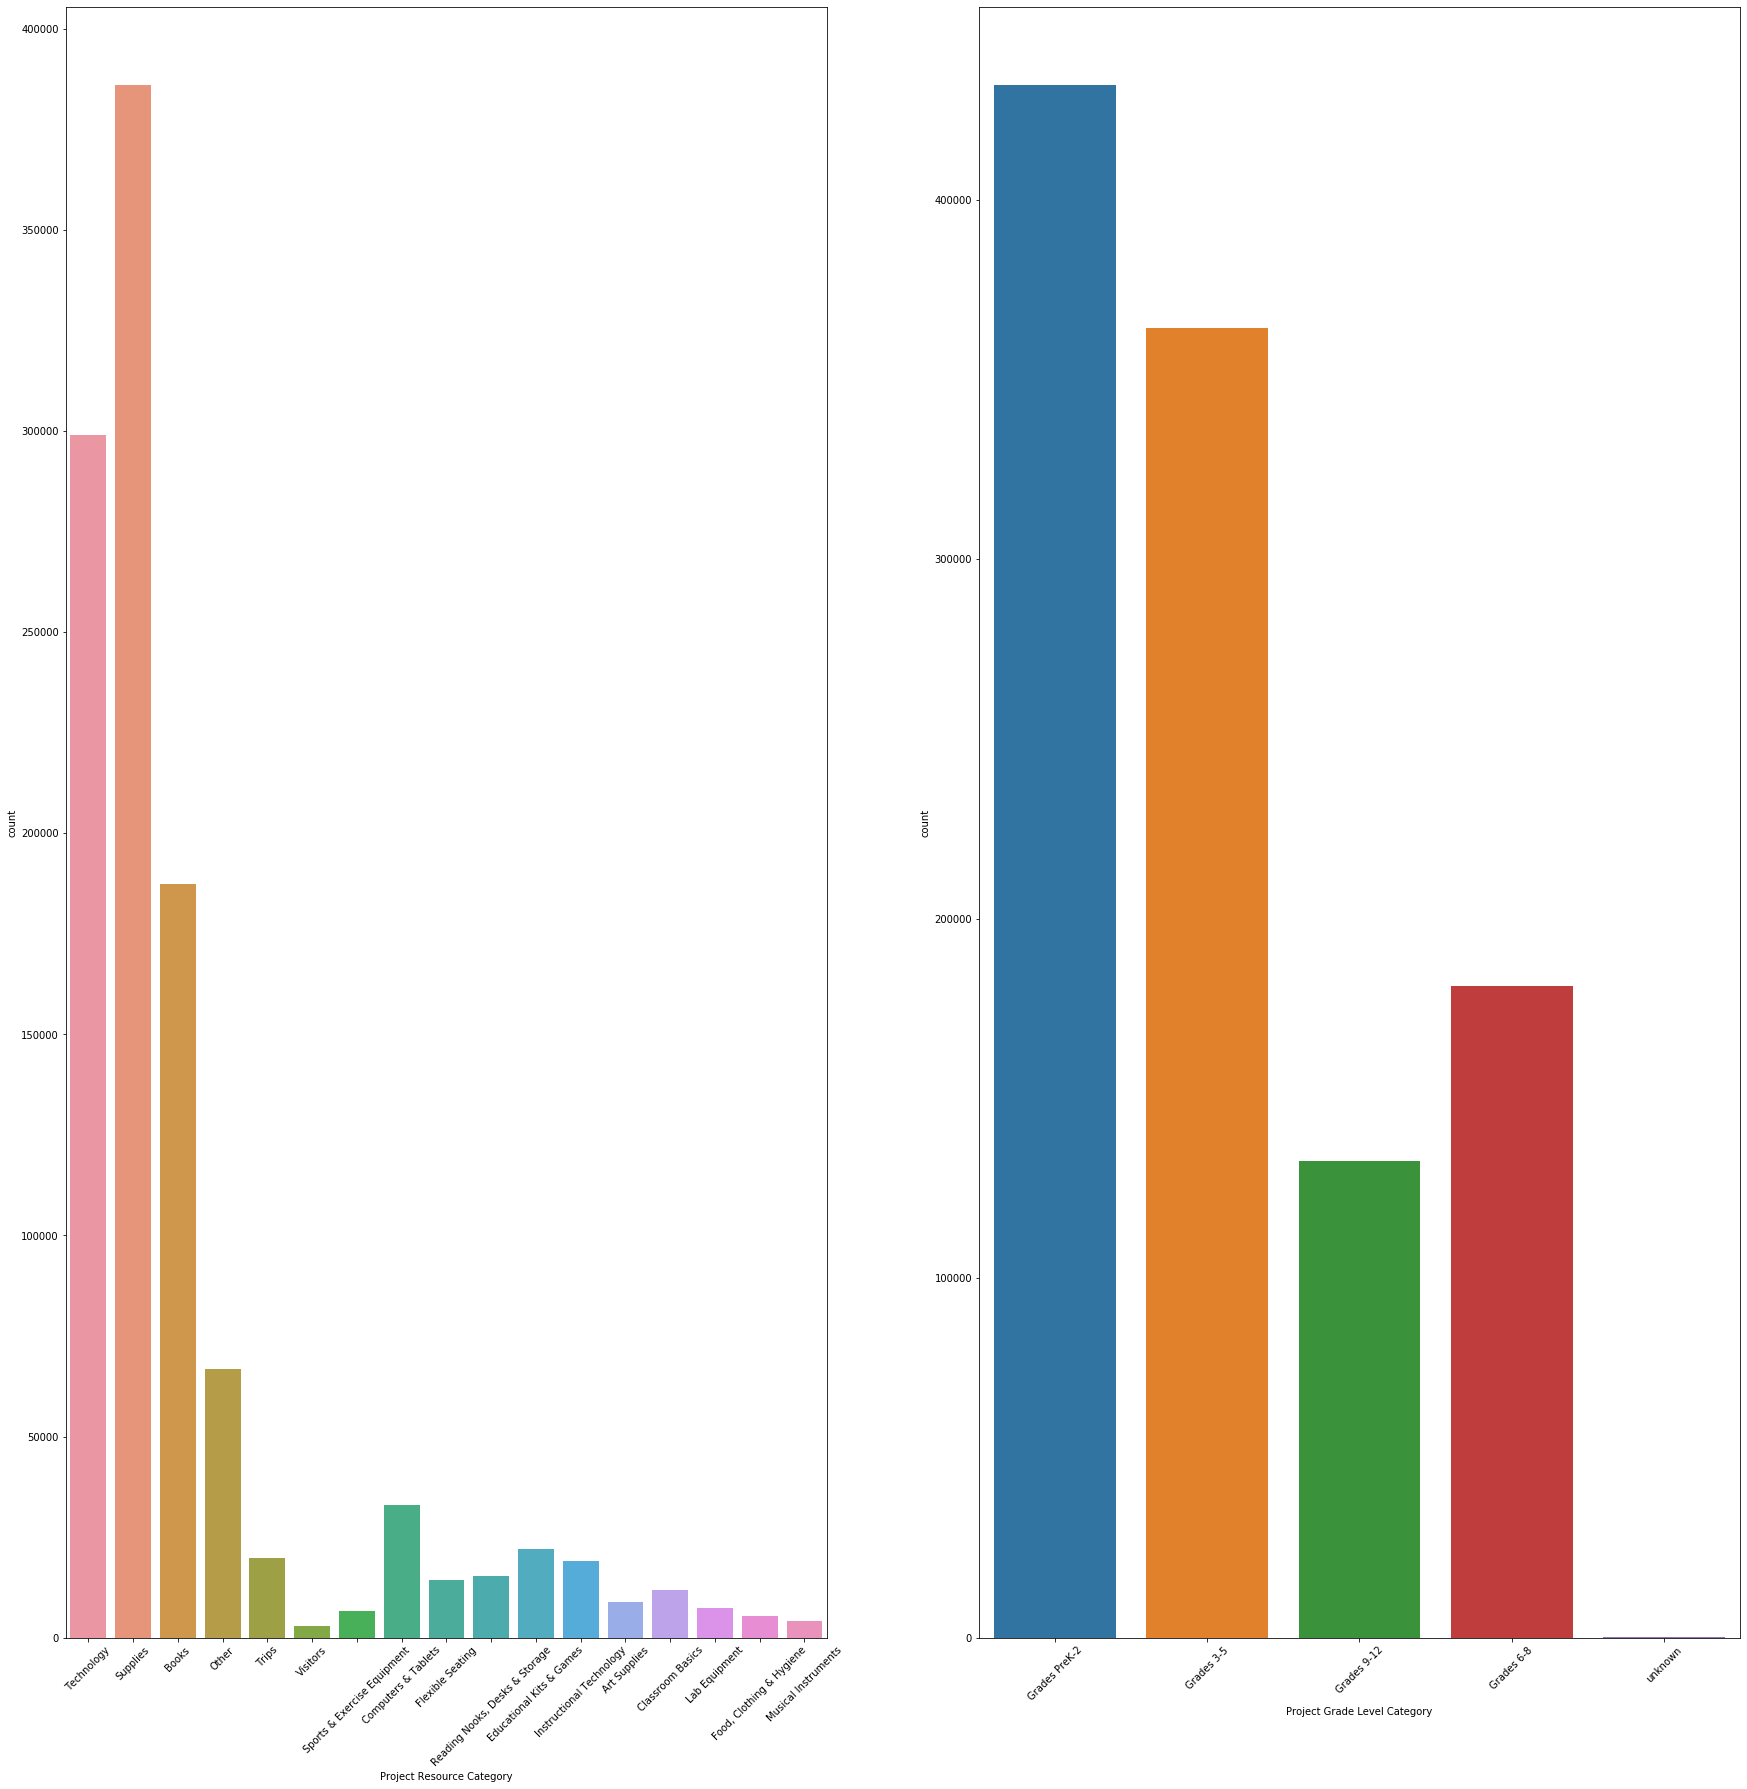

In [209]:
fig, ax = plt.subplots(1,2, figsize=(30,30))
donations_by_category = sns.countplot(data=projects, x='Project Resource Category', ax=ax[0])
project_category_count = sns.countplot(data=projects, x='Project Grade Level Category', ax=ax[1])
for a in ax:
    for tick in a.get_xticklabels():
        tick.set_rotation(45)
plt.show()
#So books, supplies and technology have the highest amount of donations

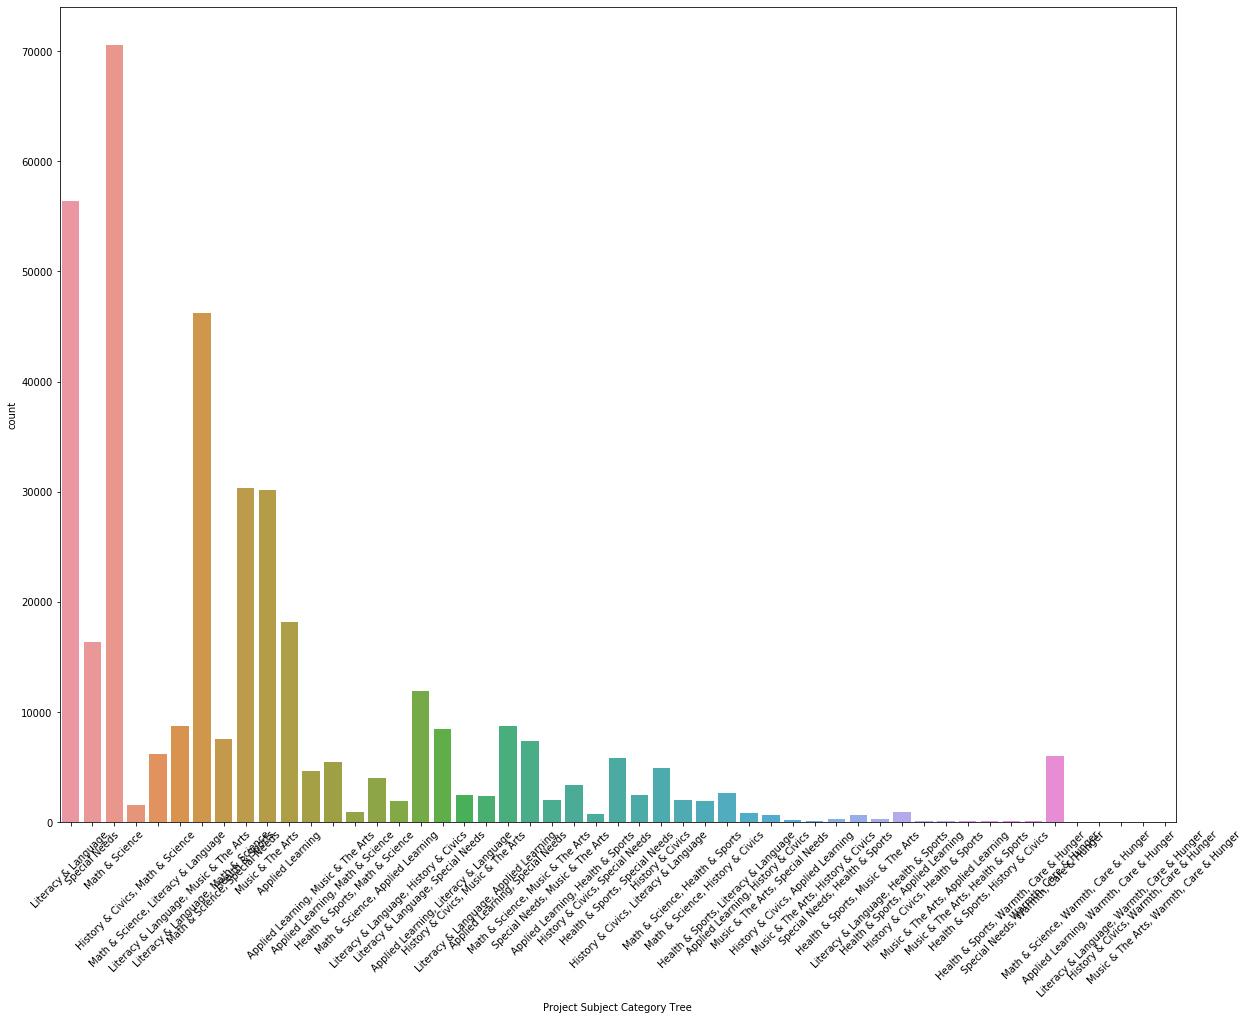

In [210]:
plt.figure(figsize=(20,15))
supplies_sub_category = sns.countplot(data=projects[projects['Project Resource Category']=='Supplies'],x='Project Subject Category Tree')
plt.xticks(rotation=45)
plt.show()

## Cleaning

In [190]:
schools['School Percentage Bins'] = pd.cut(schools['School Percentage Free Lunch'], bins=4)

In [191]:
project_columns = ['Project ID', 'School ID', 'Project Resource Category', 'Project Grade Level Category', 'Project Essay']
school_columns = ['School ID', 'School Metro Type', 'School Percentage Bins', 'School State', 'School District']
unprocessed_donations = donations[['Donation ID','Donor ID','Project ID', 'Donation Received Date']].merge(projects[project_columns], how='left', on='Project ID').merge(schools[school_columns], how='left', on='School ID')
unprocessed_donations['Donation Received Date'] = pd.to_datetime(unprocessed_donations['Donation Received Date'])

In [192]:
columns = project_columns + school_columns
for column in columns:
    print('Percentage of null values for ', column, 'is: ',(unprocessed_donations[column].isnull().sum()/ len(unprocessed_donations[column])*100) , '%')

Percentage of null values for  Project ID is:  0.0 %
Percentage of null values for  School ID is:  1.5737154073892992 %
Percentage of null values for  Project Resource Category is:  1.5765738380639296 %
Percentage of null values for  Project Grade Level Category is:  1.5737154073892992 %
Percentage of null values for  Project Essay is:  1.5739287231112866 %
Percentage of null values for  School ID is:  1.5737154073892992 %
Percentage of null values for  School Metro Type is:  1.57437668612746 %
Percentage of null values for  School Percentage Bins is:  2.042668690606237 %
Percentage of null values for  School State is:  1.57437668612746 %
Percentage of null values for  School District is:  1.57437668612746 %


In [193]:
unprocessed_donations = unprocessed_donations.dropna()
unprocessed_donations = unprocessed_donations.reset_index(drop=True)

In [194]:
donation_id_count = donations['Donor ID'].value_counts()
donation_id_count = donation_id_count.to_frame(name='donor_counts')
donation_id_count = donation_id_count.reset_index().rename(columns={'index':'Donor ID'})
unprocessed_donations = unprocessed_donations.merge(donation_id_count, how='left',on='Donor ID')

In [195]:
# Sorting by Donor ID so that the subset of the data that we keep contains all possible donation id recommendations
# This way we can properly evaluate our recommendations 
unprocessed_donations = unprocessed_donations[unprocessed_donations['donor_counts']>1]
unprocessed_donations = unprocessed_donations.sort_values(by='Donor ID')
unprocessed_donations = unprocessed_donations.iloc[:2300,:]
unprocessed_donations = unprocessed_donations.reset_index(drop=True)

## Content-based recommendation calculation

In [197]:
def get_donation_id(donor_id,transaction_number='first'):
    donations = unprocessed_donations[unprocessed_donations['Donor ID']==donor_id].sort_values(by='Donation Received Date')['Donation ID'].to_numpy()
    if transaction_number=='first':
        return donations[0]
    elif transaction_number=='last':
        return donations[len(donations)-1]    
    
def get_recommendation(donation_id, mapping):
    index = mapping[donation_id]
    similarity_scores = list(enumerate(similarity_matrix[index]))
    similarity_scores = sorted(similarity_scores, key=lambda score:score[1], reverse=True)
    donation_indeces = [score[0] for score in similarity_scores[:5]]
    return unprocessed_donations['Project ID'].iloc[donation_indeces].tolist()                        

## Content-based recommendatioon (Project and School features)

In [198]:
enc = OneHotEncoder()
encoded = enc.fit_transform(unprocessed_donations[['Project Resource Category', 'Project Grade Level Category', 'School State']]).toarray()
feature_labels = enc.get_feature_names()
processed_donations = pd.DataFrame(encoded, columns=feature_labels)
processed_donations = processed_donations.apply(lambda x: x.astype('bool'))

In [200]:
similarity_matrix = pairwise_distances(processed_donations.to_numpy(), processed_donations.to_numpy(),metric='jaccard')
mapping = pd.Series(processed_donations.index, index=unprocessed_donations['Donation ID'])

### Evaluation

In [201]:
unique_donor_ids = unprocessed_donations['Donor ID'].unique()
actual_donations = []
predicted_donations = []
for i in range(len(unique_donor_ids)):
    donor_id = unique_donor_ids[i]
    donation_id = get_donation_id(donor_id, transaction_number='first')
    predicted_donations.append(get_recommendation(donation_id, mapping))
    actual_donations.append(unprocessed_donations[unprocessed_donations['Donor ID']==donor_id]['Project ID'].tolist())

In [202]:
mapk(actual_donations, predicted_donations, 5)

0.001

In [ ]:
features = ['Project Resource Category', 'Project Grade Level Category ', 'School Percentage Free Lunch',  'School State', 'School Metro Type', 'Project Type']

#bin school percentage free lunch

## Content-based recommendations (Project Essay)

In [203]:
def get_essay_key_words(project_essay):
    ''' Rake removes stopwords and punctuation '''
    r = Rake()
    r.extract_keywords_from_text(project_essay)
    keyword_scores = r.get_word_degrees()
    keywords = [keyword.lower() for keyword in list(keyword_scores.keys())]
    keywords = " ".join(keywords)
    return keywords

df_donations_essay = unprocessed_donations[['Donation ID', 'Donor ID', 'Project Essay']]
df_donations_essay['project_essay_keywords'] = df_donations_essay.apply(lambda row: get_essay_key_words(row['Project Essay']),axis=1)


/Users/carlaleal/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [204]:
tfidf = TfidfVectorizer()
frequency_matrix = tfidf.fit_transform(df_donations_essay['project_essay_keywords'])
similarity_matrix = pairwise_distances(frequency_matrix, frequency_matrix, metric='cosine')
mapping = pd.Series(df_donations_essay.index, index=df_donations_essay['Donation ID'])

### Evaluation

In [205]:
unique_donor_ids = unprocessed_donations['Donor ID'].unique()
actual_donations = []
predicted_donations = []
for i in range(len(unique_donor_ids)):
    donor_id = unique_donor_ids[i]
    donation_id = get_donation_id(donor_id, transaction_number='first')
    predicted_donations.append(get_recommendation(donation_id, mapping))
    actual_donations.append(unprocessed_donations[unprocessed_donations['Donor ID']==donor_id]['Project ID'].tolist())

In [206]:
mapk(actual_donations, predicted_donations, 5)

0.0015432098765432098

## Collaborative Filtering 

In [159]:
def df_to_dataset(dataframe,batch_size=1000):
    dataframe = dataframe.copy()
    ds = tf.data.Dataset.from_tensor_slices(dict(dataframe))
    ds = ds.prefetch(batch_size)
    return ds

In [164]:
donations_df = unprocessed_donations[['Donor ID', 'Project ID']]
projects_df = pd.DataFrame({'Project ID':donations_df['Project ID'].drop_duplicates()})
donations_ds = df_to_dataset(donations_df)
projects_ds = df_to_dataset(projects_df)

donations_ds = donations_ds.map(lambda x: {'Donor ID': x['Donor ID'],'Project ID':x['Project ID']})
projects_ds = projects_ds.map(lambda x: x["Project ID"])

In [216]:
class ProjectRecommendationModel(tfrs.Model):
    def __init__(self):
        super().__init__()

        embedding_dim = 32
        num_unique_donors = 450
        num_unique_projects = 1899
        eval_batch_size = 50
        self.donor_model = tf.keras.Sequential([
            tf.keras.layers.experimental.preprocessing.StringLookup(
              max_tokens=num_unique_donors),
            tf.keras.layers.Embedding(num_unique_donors, embedding_dim)
        ])
        self.project_model = tf.keras.Sequential([
            tf.keras.layers.experimental.preprocessing.StringLookup(
              max_tokens=num_unique_projects),
            tf.keras.layers.Embedding(num_unique_projects, embedding_dim)])
        self.task = tfrs.tasks.Retrieval(
            metrics=tfrs.metrics.FactorizedTopK(
            candidates=projects_ds.batch(eval_batch_size).map(self.project_model)
        )
            )

    def compute_loss(self, features, training=False):
        user_embeddings = self.donor_model(features["Donor ID"])
        project_embeddings = self.project_model(features["Project ID"])
        return self.task(user_embeddings, project_embeddings)

In [217]:
model = ProjectRecommendationModel()
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))
model.fit(donations_ds.batch(4096), verbose=False)

In [218]:
index = tfrs.layers.factorized_top_k.BruteForce(model.donor_model)
index.index(projects_ds.batch(100).map(model.project_model), projects_ds)

In [219]:
_, projects = index(tf.constant(["42"]))
print(f"Recommendations for user 42: {projects[0, :3]}")

Recommendations for user 42: [b'e09933470f4256cc2643341c1d299e55' b'e2beb818569f66adaa4ced21ca299ac6'
 b'eb6d91cbeab5037ca2f45fc3f6a4de8c']
